In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.optimize import curve_fit
from numpy.polynomial import polynomial as P
from scipy.integrate import solve_ivp
np.seterr(divide="raise", over="raise", invalid="raise")
import matplotlib.colors as colors

In [ ]:
def N_a1(e2):
  return ( 1 + (31./2)*e2 + (255./8)*e2**2 + (185./16)*e2**3 + (85./64)*e2**4 ) / pow((1 - e2),15./2)
def N_a2(e2):
  return ( 1 + (15./2)*e2 + (45./8)*e2**2 + (5./16)*e2**3 ) / pow((1 - e2),6)
def N_e1(e2):
  return ( 1 + (15./4)*e2 + (15./8)*e2**2 + (5./64)*e2**3 ) / pow((1 - e2), 13./2)
def N_e2(e2):
  return ( 1 + (3./2)*e2 + (1./8)*e2**2 ) / pow((1 - e2), 5.)
def N_o1(e2):
  return ( 1 + (15./2)*e2 + (45./8)*e2**2 + (5./16)*e2**3 ) / pow((1 - e2), 13./2)
def N_o2(e2):
  return ( 1 + 3*e2 + (3./8)*e2**2 ) / pow((1 - e2), 5.)

# **Jupiter - Europa case**

To calculate the dissipation parameter $\sigma_p$ we can use the formula: $ k_2 \Delta T_p = \frac{3}{2} \frac{R_p^5 \sigma_p}{G}$. \\
For Jupiter I use $\sigma_J = 2.006 \cdot 10^{-60} \frac{1}{g \cdot cm^2 \cdot s}$ (Bolmont, Raymond and Leconte 2011). \\
For Europa I use $k_2 = 0.6295$ and the time lag is $\Delta T = \frac{1}{2 \Omega_J Q} = 28.4 s$. \\
The dissipation parameter of Europa is $\sigma_m = 8.5769 \cdot 10^{-41} \frac{1}{g \cdot cm^2 \cdot s}$



In [ ]:
def equations(t, y, m, r, sigma_m, M, sigma_M): 
  a, e, Period_m, Omega_M = y
  G = 6.674e-8

  Period_m = (2*np.pi)/np.sqrt(G*(M+m)) * pow(a,1.5)       #Assuming sincronous rotation!
  Omega_m = (2*np.pi) / Period_m

  dRdt = - 0.6 * 7.149e9 / ((1e10 - 1e6) * 3.154e7)
  R =  1 * 7.149e9 + t * dRdt #Jupiter radii in cm
  #print(R / 7.149e9)
  
  T_m     = (1./9) * (m/(M*(M + m))) * (1. / pow(r, 10)) * (1./sigma_m) * pow(a, 8)
  T_M     = (1./9) * (M/(m*(M + m))) * (1. / R**10) * (1./sigma_M) * a**8 
  n       = np.sqrt(G * (M+m)/pow(a,3))
  h       = (m*M)/(m+M) * np.sqrt(G * (m + M) * a * (1-e**2))
  #I_m     = 2./5 * m * r**2
  I_M     = 2./5 * M * R**2
  #gamma_m = h / I_m / Omega_m
  gamma_M = h / I_M / Omega_M

  dadt      = ((-a/T_m) * (N_a1(e**2) - (Omega_m / n) * N_a2(e**2))) + ((-a/T_M) * (N_a1(e**2) - (Omega_M / n) * N_a2(e**2)))
  dedt      = (- 9*e/2./T_m * (N_e1(e**2) - (11./18) * (Omega_m/n) * N_e2(e**2))) + (-9*e/2./T_M * (N_e1(e**2) - (11./18) * (Omega_M/n) * N_e2(e**2))) 
  dPeriodm_dt = 3*np.pi / np.sqrt(G*(M+m)) * np.sqrt(a) * dadt
  dOmegaMdt = - Omega_M * gamma_M / (2. * T_M) * (N_o1(e**2) - (Omega_M / n) * N_o2(e**2)) - 2./ R * dRdt 

  dydt = [dadt, dedt, dPeriodm_dt, dOmegaMdt]
  return dydt

In [ ]:
G = 6.674e-8
m = 4.80e25          #Europa mass in g            
r = 1.5608e8         #Europa radius        
sigma_m = 8.5769e-46 # 1./(g*cm^2*s)

#sigma_m = 8.5769e-48 # 1./(g*cm^2*s)
M = 1.898e30         #Jupiter mass in g
sigma_M = 2.006e-60  # 1./(g*cm^2*s)

tin  = 1e6 * 3.154e7
tfin = 1e10*3.154e7

a0 = 6.70900e10
e0 = 0.009
Period_m0 = (2*np.pi)/np.sqrt(G*(M+m)) * pow(a0,1.5)
Omega_M0 = (2*np.pi)/(9.8 * 3600)

y0 = [a0, e0, Period_m0, Omega_M0]
sol = solve_ivp(equations, [tin, tfin], y0, method = 'BDF', rtol = 1e-12, atol = 1e-40, args=(m, r, sigma_m, M, sigma_M))
if not sol.success:
    print(sol.message)
    Error

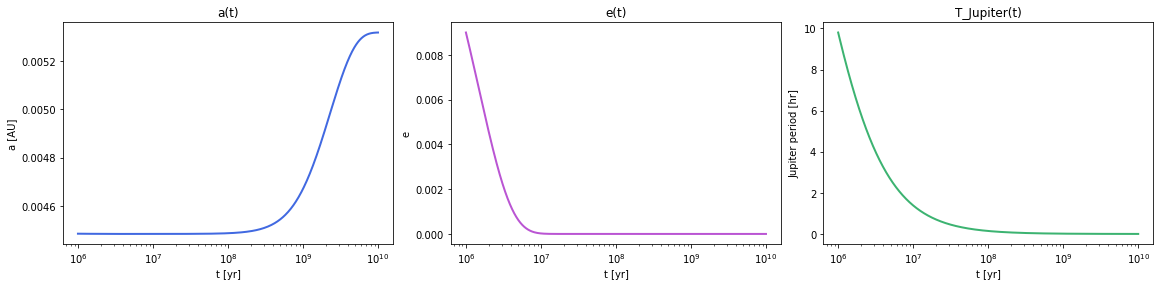

In [ ]:
fig = plt.figure(figsize=(16,5), constrained_layout = True)
gs = GridSpec(4, 9, figure = fig)
ax1 = fig.add_subplot(gs[0:3,0:3])
ax2 = fig.add_subplot(gs[0:3,3:6])
ax3 = fig.add_subplot(gs[0:3,6:9])

ax1.plot(sol.t / 3.154e7, sol.y[0] * 6.685e-14, 'b', color = 'royalblue', lw=2)
ax1.set_xscale('log')
ax1.set_xlabel('t [yr]')
ax1.set_ylabel('a [AU]')
ax1.set_title('a(t)')

ax2.plot(sol.t / 3.154e7, sol.y[1], 'b', color = 'mediumorchid', lw=2)
ax2.set_xscale('log')
ax2.set_xlabel('t [yr]')
ax2.set_ylabel('e')
ax2.set_title('e(t)')

ax3.plot(sol.t / 3.154e7, (2 * np.pi) / (sol.y[3] * 3600), 'b', color = 'mediumseagreen', lw=2)
ax3.set_xscale('log')
ax3.set_xlabel('t [yr]')
ax3.set_ylabel('Jupiter period [hr]')
ax3.set_title('T_Jupiter(t)')

fig.savefig('Jupiter-Europa.png', dpi=600)
fig.show()

# **Jupiter - Earth system**

For the Earth $k_2 \Delta T_p = 213 s$. (Neron de Surgy and Laskar, 1997). \\
$\sigma_{Earth} = 8.9795 \cdot 10^{-50} \frac{1}{g \cdot cm^2 \cdot s}$

In [ ]:
def equations(t, y, m, r, sigma_m, M, sigma_M): 
  a, e, Period_m, Omega_M = y
  G = 6.674e-8

  Period_m = (2*np.pi)/np.sqrt(G*(M+m)) * pow(a,1.5)       #Assuming sincronous rotation!
  Omega_m = (2*np.pi) / Period_m

  dRdt = - 0.6 * 7.149e9 / ((1e10 - 1e6) * 3.154e7)
  R =  1 * 7.149e9 + t * dRdt #Jupiter radii in cm
  #print(R / 7.149e9)
  
  T_m     = (1./9) * (m/(M*(M + m))) * (1. / r**10) * (1./sigma_m) * a**8 
  T_M     = (1./9) * (M/(m*(M + m))) * (1. / R**10) * (1./sigma_M) * a**8 
  n       = np.sqrt(G * (M+m)/pow(a,3))
  h       = (m*M)/(m+M) * np.sqrt(G * (m + M) * a * (1-e**2))
  #I_m     = 2./5 * m * r**2
  I_M     = 2./5 * M * R**2
  #gamma_m = h / I_m / Omega_m
  gamma_M = h / I_M / Omega_M

  dadt      = ((-a/T_m) * (N_a1(e**2) - (Omega_m / n) * N_a2(e**2))) + ((-a/T_M) * (N_a1(e**2) - (Omega_M / n) * N_a2(e**2)))
  dedt      = (- 9*e/2./T_m * (N_e1(e**2) - (11./18) * (Omega_m/n) * N_e2(e**2))) + (-9*e/2./T_M * (N_e1(e**2) - (11./18) * (Omega_M/n) * N_e2(e**2))) 
  dPeriodm_dt = 3*np.pi / np.sqrt(G*(M+m)) * np.sqrt(a) * dadt
  dOmegaMdt = - Omega_M * gamma_M / (2. * T_M) * (N_o1(e**2) - (Omega_M / n) * N_o2(e**2)) - 2./ R * dRdt 

  dydt = [dadt, dedt, dPeriodm_dt, dOmegaMdt]
  return dydt

In [ ]:
G = 6.674e-8
m = 5.972e27         #Earth mass in g            
r = 6.378e8          #Earth radius        
sigma_m = 8.9795e-50 # 1./(g*cm^2*s)
M = 1.898e30         #Jupiter mass in g
sigma_M = 2.006e-60  # 1./(g*cm^2*s)

tin  = 1e4 * 3.154e7
tfin = 1e7 * 3.154e7

a0 = 6.70900e10
e0 = 0.1
Period_m0 = (2*np.pi)/np.sqrt(G*(M+m)) * pow(a0,1.5)
Omega_M0 = (2*np.pi)/(9.8 * 3600)

y0 = [a0, e0, Period_m0, Omega_M0]
sol = solve_ivp(equations, [tin, tfin], y0, method = 'BDF', rtol = 1e-12, atol = 1e-40, args=(m, r, sigma_m, M, sigma_M))
if not sol.success:
    print(sol.message)
    Error

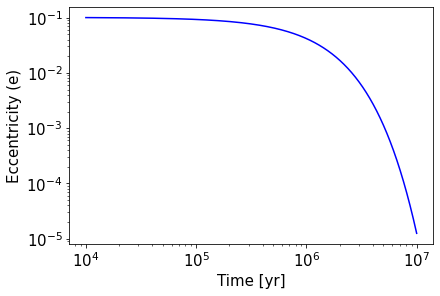

In [ ]:
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(sol.t / 3.154e7, sol.y[1], 'b')
ax.set_xlabel('Time [yr]', fontsize=15)
ax.set_ylabel('Eccentricity (e)', fontsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_xlim(1e4,1e7)
#ax.set_ylim(1e-6,1e-1)
plt.savefig('prova.png', dpi=600)
plt.show()

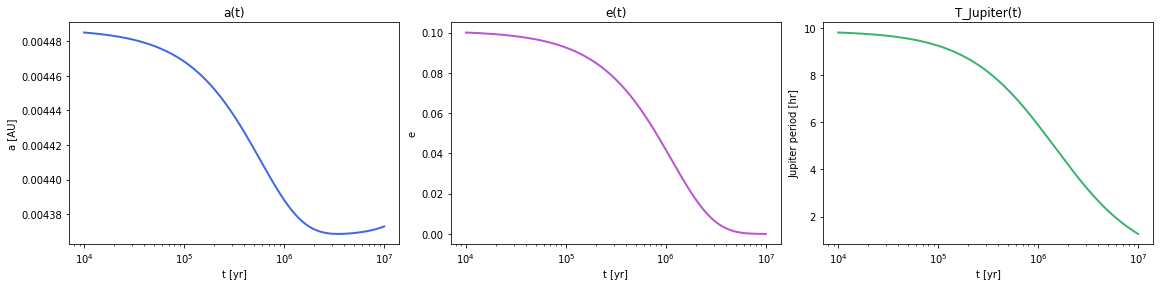

In [ ]:
fig = plt.figure(figsize=(16,5), constrained_layout = True)
gs = GridSpec(4, 9, figure = fig)
ax1 = fig.add_subplot(gs[0:3,0:3])
ax2 = fig.add_subplot(gs[0:3,3:6])
ax3 = fig.add_subplot(gs[0:3,6:9])

ax1.plot(sol.t / 3.154e7, sol.y[0] * 6.685e-14, 'b', color = 'royalblue', lw=2)
ax1.set_xscale('log')
ax1.set_xlabel('t [yr]')
ax1.set_ylabel('a [AU]')
ax1.set_title('a(t)')

ax2.plot(sol.t / 3.154e7, sol.y[1], 'b', color = 'mediumorchid', lw=2)
ax2.set_xscale('log')
ax2.set_xlabel('t [yr]')
ax2.set_ylabel('e')
ax2.set_title('e(t)')

ax3.plot(sol.t / 3.154e7, (2 * np.pi) / (sol.y[3] * 3600), 'b', color = 'mediumseagreen', lw=2)
ax3.set_xscale('log')
ax3.set_xlabel('t [yr]')
ax3.set_ylabel('Jupiter period [hr]')
ax3.set_title('T_Jupiter(t)')

fig.savefig('Jupiter-Earth.png', dpi=600)
fig.show()

# **Angular frequency not synchronized**

In [ ]:
def equations(t, y, m, r, sigma_m, M, sigma_M): 
  a, e, Omega_m, Omega_M = y
  G = 6.674e-8

  #Period_m = (2*np.pi)/np.sqrt(G*(M+m)) * pow(a,1.5)       #Assuming sincronous rotation!
  #Omega_m = (2*np.pi) / Period_m

  #dRdt = - 0.3 * 7.149e9 / ((1e7 - 1e4) * 3.154e7)
  #R =  1 * 7.149e9 + t * dRdt #Jupiter radii in cm
  R = 1 * 7.149e9
  #print(R / 7.149e9)
  
  T_m     = (1./9) * (m/(M*(M + m))) * (1. / r**10) * (1./sigma_m) * a**8 
  T_M     = (1./9) * (M/(m*(M + m))) * (1. / R**10) * (1./sigma_M) * a**8 
  n       = np.sqrt(G * (M+m)/pow(a,3))
  h       = (m*M)/(m+M) * np.sqrt(G * (m + M) * a * (1-e**2))
  I_m     = 2./5 * m * r**2
  I_M     = 2./5 * M * R**2
  gamma_m = h / I_m / Omega_m
  gamma_M = h / I_M / Omega_M

  dadt      = ((-a/T_m) * (N_a1(e**2) - (Omega_m / n) * N_a2(e**2))) + ((-a/T_M) * (N_a1(e**2) - (Omega_M / n) * N_a2(e**2)))
  dedt      = (- 9*e/2./T_m * (N_e1(e**2) - (11./18) * (Omega_m/n) * N_e2(e**2))) + (-9*e/2./T_M * (N_e1(e**2) - (11./18) * (Omega_M/n) * N_e2(e**2))) 
  #dPeriodm_dt = 3*np.pi / np.sqrt(G*(M+m)) * np.sqrt(a) * dadt
  dOmegamdt = Omega_m * gamma_m / 2 / T_m * (N_o1(e**2) - Omega_m / n * N_o2(e**2))
  #dOmegaMdt = - Omega_M * gamma_M / (2. * T_M) * (N_o1(e**2) - (Omega_M / n) * N_o2(e**2)) - 2./ R * dRdt 
  dOmegaMdt = - Omega_M * gamma_M / (2. * T_M) * (N_o1(e**2) - (Omega_M / n) * N_o2(e**2)) 

  dydt = [dadt, dedt, dOmegamdt, dOmegaMdt]
  return dydt

In [ ]:
G = 6.674e-8
m = 5.972e27         #Earth mass in g            
r = 6.378e8          #Earth radius        
sigma_m = 8.9795e-50 # 1./(g*cm^2*s)
M = 1.898e30         #Jupiter mass in g
sigma_M = 2.006e-60  # 1./(g*cm^2*s)

tin  = 1e4 * 3.154e7
tfin = 1e7 * 3.154e7

a0 = 6.70900e10
e0 = 0.1
#Period_m0 = (2*np.pi)/np.sqrt(G*(M+m)) * pow(a0,1.5)
Omega_m0 = (2*np.pi)/(24 * 3600)
Omega_M0 = (2*np.pi)/(9.8 * 3600)


y0 = [a0, e0, Omega_m0, Omega_M0]
sol = solve_ivp(equations, [tin, tfin], y0, method = 'BDF', rtol = 1e-12, atol = 1e-40, args=(m, r, sigma_m, M, sigma_M))
if not sol.success:
    print(sol.message)
    Error

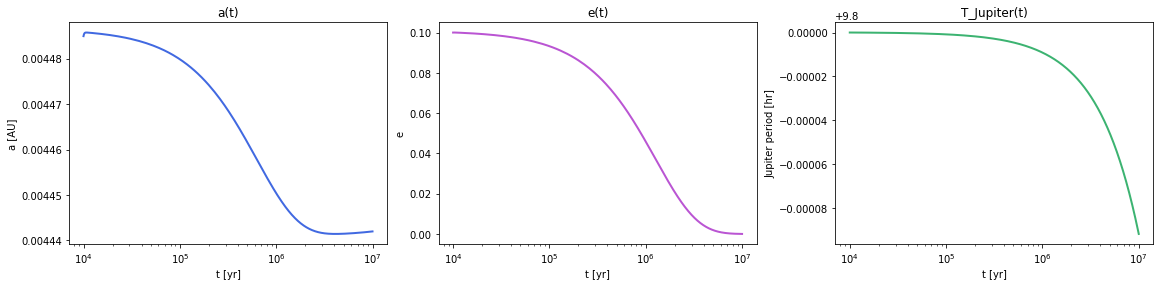

In [ ]:
fig = plt.figure(figsize=(16,5), constrained_layout = True)
gs = GridSpec(4, 9, figure = fig)
ax1 = fig.add_subplot(gs[0:3,0:3])
ax2 = fig.add_subplot(gs[0:3,3:6])
ax3 = fig.add_subplot(gs[0:3,6:9])

ax1.plot(sol.t / 3.154e7, sol.y[0] * 6.685e-14, 'b', color = 'royalblue', lw=2)
ax1.set_xscale('log')
ax1.set_xlabel('t [yr]')
ax1.set_ylabel('a [AU]')
ax1.set_title('a(t)')

ax2.plot(sol.t / 3.154e7, sol.y[1], 'b', color = 'mediumorchid', lw=2)
ax2.set_xscale('log')
ax2.set_xlabel('t [yr]')
ax2.set_ylabel('e')
ax2.set_title('e(t)')

ax3.plot(sol.t / 3.154e7, (2 * np.pi) / (sol.y[3] * 3600), 'b', color = 'mediumseagreen', lw=2)
ax3.set_xscale('log')
ax3.set_xlabel('t [yr]')
ax3.set_ylabel('Jupiter period [hr]')
ax3.set_title('T_Jupiter(t)')

#fig.savefig('Jupiter-Earth.png', dpi=600)
fig.show()

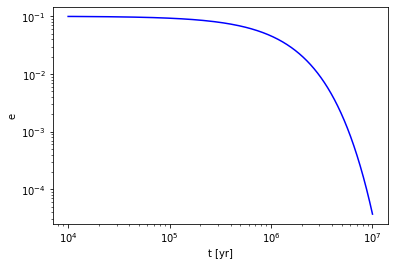

In [ ]:
plt.figure(1)
plt.plot(sol.t / 3.154e7, sol.y[1], 'b')
plt.xlabel('t [yr]')
plt.ylabel('e')
plt.xscale('log')
plt.yscale('log')
#plt.savefig('prova.jpg', dpi=600)
plt.show()

# **Jupiter - Earth system as in the paper**

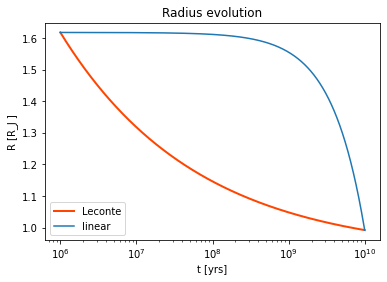

In [ ]:
def jupiter_radius(t, A, B, C):
  return A * np.exp(-B * np.log10(t)) + C

A = 20.043 * 7.149e9 #cm
B = 0.559  #adimentional
C = 0.917 * 7.149e9 #cm

t = np.logspace(np.log10(1e6), np.log10(1e10 ), 10000) 
ev2 = 1.61738854 - (1.61738854 - 0.99186116) / ((1e10 - 1e6) ) * t


plt.plot(t , jupiter_radius(t, A, B, C) / 7.149e9, color = 'orangered', lw = 2, label = 'Leconte')
plt.plot(t, ev2, label = 'linear')
plt.title('Radius evolution')
plt.xlabel('t [yrs]')
plt.ylabel('R [R_J ]')
plt.xscale('log')
plt.legend()
#plt.savefig('Radius_linear.png', dpi=600)

In [ ]:
dRdt = - A * B * np.exp(- B * np.log10(t /  3.154e7)) / (np.log(10) * (t / 3.154e7)) 
R = jupiter_radius(t / 3.154e7, A, B, C) #cm

In [ ]:
def equations(t, y, m, r, sigma_m, M, sigma_M): 
  a, e, Omega_m, Omega_M = y
  G = 6.674e-8

  #Period_m = (2*np.pi)/np.sqrt(G*(M+m)) * pow(a,1.5)       #Assuming sincronous rotation!
  #Omega_m = (2*np.pi) / Period_m

  #dRdt = - (1.61738854 - 0.99186116) * 7.149e9 / ((1e10 - 1e6) * 3.154e7)
  #R = 1.61738854 * 7.149e9 + t * dRdt #Jupiter radii in cm
  #R = 1 * 7.149e9
  #print(R / 7.149e9)
  dRdt = - A * B * np.exp(- B * np.log10(t /  3.154e7)) / (np.log(10) * (t )) 
  R = jupiter_radius(t / 3.154e7, A, B, C) #cm
  
  T_m     = (1./9) * (m/(M*(M + m))) * (1. / r**10) * (1./sigma_m) * a**8 
  T_M     = (1./9) * (M/(m*(M + m))) * (1. / R**10) * (1./sigma_M) * a**8 
  n       = np.sqrt(G * (M+m)/pow(a,3))
  h       = (m*M)/(m+M) * np.sqrt(G * (m + M) * a * (1-e**2))
  I_m     = 2./5 * m * r**2
  I_M     = 2./5 * M * R**2
  gamma_m = h / I_m / Omega_m
  gamma_M = h / I_M / Omega_M

  dadt      = ((-a/T_m) * (N_a1(e**2) - (Omega_m / n) * N_a2(e**2))) + ((-a/T_M) * (N_a1(e**2) - (Omega_M / n) * N_a2(e**2)))
  dedt      = (- 9*e/2./T_m * (N_e1(e**2) - (11./18) * (Omega_m/n) * N_e2(e**2))) + (-9*e/2./T_M * (N_e1(e**2) - (11./18) * (Omega_M/n) * N_e2(e**2))) 
  #dPeriodm_dt = 3*np.pi / np.sqrt(G*(M+m)) * np.sqrt(a) * dadt
  dOmegamdt = Omega_m * gamma_m / 2 / T_m * (N_o1(e**2) - Omega_m / n * N_o2(e**2))
  dOmegaMdt = - Omega_M * gamma_M / (2. * T_M) * (N_o1(e**2) - (Omega_M / n) * N_o2(e**2)) - 2./ R * dRdt 
  #dOmegaMdt = - Omega_M * gamma_M / (2. * T_M) * (N_o1(e**2) - (Omega_M / n) * N_o2(e**2)) 

  #print(a, e, Omega_m, Omega_M)
  #print(h, gamma_m, gamma_M)
  #print(T_m, T_M, I_m, I_M, n)
  #print(T_M, R / 7.149e9, a)

  dydt = [dadt, dedt, dOmegamdt, dOmegaMdt]
  return dydt

In [ ]:
G = 6.674e-8
m = 5.972e27         #Earth mass in g            
r = 6.378e8          #Earth radius        
sigma_m = 8.9795e-50 # 1./(g*cm^2*s)
M = 1.898e30         #Jupiter mass in g
sigma_M = 2.006e-60  # 1./(g*cm^2*s)

tin  = 1e6 * 3.154e7
tfin = 1e10 * 3.154e7

a0 = 2e-2 * 1.496e+13
e0 = 1e-1
#Period_m0 = (2*np.pi)/np.sqrt(G*(M+m)) * pow(a0,1.5)
Omega_m0 = (2*np.pi)/(24 * 3600)
Omega_M0 = (2*np.pi)/(9.8 * 3600)


y0 = [a0, e0, Omega_m0, Omega_M0]
sol = solve_ivp(equations, [tin, tfin], y0, method = 'BDF', rtol = 1e-12, atol = 1e-40, args=(m, r, sigma_m, M, sigma_M))
if not sol.success:
    print(sol.message)
    Error

Text(0.5, 1.0, 'T_Earth(t)')

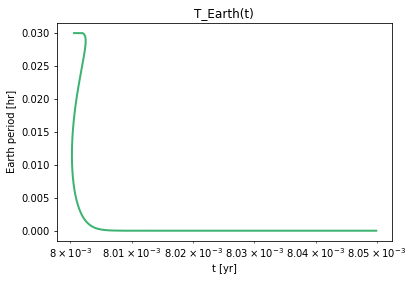

In [ ]:
plt.plot(sol.y[0] * 6.685e-14, sol.y[1], 'b', color = 'mediumseagreen', lw=2)
plt.xscale('log')
plt.xlabel('t [yr]')
plt.ylabel('Earth period [hr]')
plt.title('T_Earth(t)')

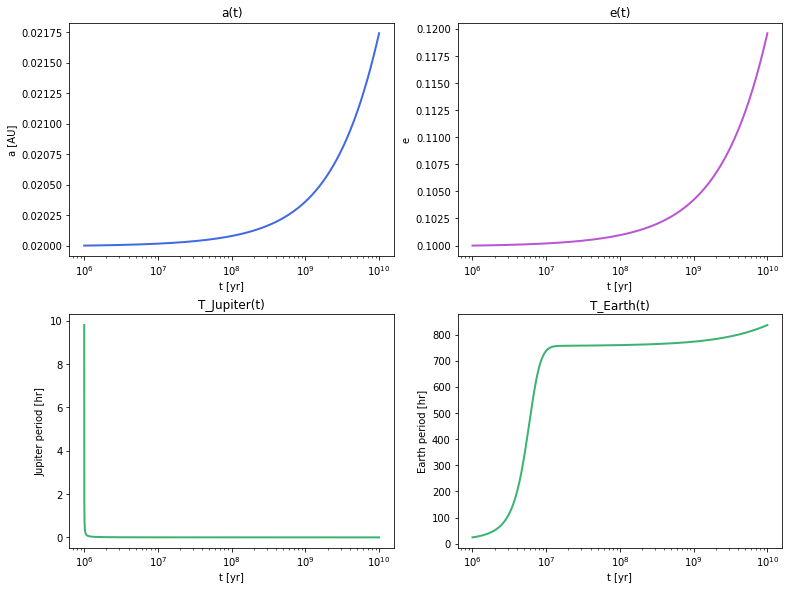

In [ ]:
fig = plt.figure(figsize=(12,9), constrained_layout = True)
gs = GridSpec(9, 9, figure = fig)
ax1 = fig.add_subplot(gs[0:4,0:4])
ax2 = fig.add_subplot(gs[0:4,4:8])
ax3 = fig.add_subplot(gs[4:8,0:4])
ax4 = fig.add_subplot(gs[4:8,4:8])

ax1.plot(sol.t / 3.154e7, sol.y[0] * 6.685e-14, 'b', color = 'royalblue', lw=2)
ax1.set_xscale('log')
ax1.set_xlabel('t [yr]')
ax1.set_ylabel('a [AU]')
ax1.set_title('a(t)')

ax2.plot(sol.t / 3.154e7, sol.y[1], 'b', color = 'mediumorchid', lw=2)
ax2.set_xscale('log')
ax2.set_xlabel('t [yr]')
ax2.set_ylabel('e')
ax2.set_title('e(t)')

ax3.plot(sol.t / 3.154e7, (2 * np.pi) / (sol.y[3] * 3600), 'b', color = 'mediumseagreen', lw=2)
ax3.set_xscale('log')
ax3.set_xlabel('t [yr]')
ax3.set_ylabel('Jupiter period [hr]')
ax3.set_title('T_Jupiter(t)')

ax4.plot(sol.t / 3.154e7, (2 * np.pi) / (sol.y[2] * 3600), 'b', color = 'mediumseagreen', lw=2)
ax4.set_xscale('log')
ax4.set_xlabel('t [yr]')
ax4.set_ylabel('Earth period [hr]')
ax4.set_title('T_Earth(t)')

fig.savefig('Jupiter-Earth.png', dpi=600)
fig.show()

Text(0.5, 1.0, 'e vs a')

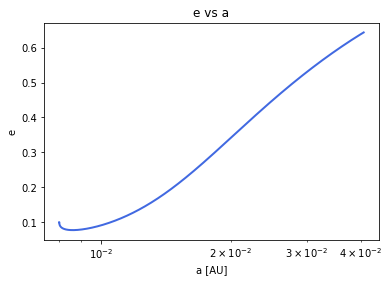

In [ ]:
plt.figure(1)
plt.plot(sol.y[0] * 6.685e-14, sol.y[1], 'b', color = 'royalblue', lw=2)
plt.xscale('log')
plt.xlabel('a [AU]')
plt.ylabel('e')
plt.title('e vs a')

Now I can plot the evolution over the surface temperature.

In [ ]:
a_ev = sol.y[0] *1e-2
e_ev = sol.y[1]

E_radio = 3e13 
sigma_B = 5.6704e-8
D = 1.5
epsilon_r = 0.9
G = 6.67e-11
Q = 100 
M_J = 1.898e27
R = 6.371e6
def n(m, a):
  return np.sqrt(G*(M_J + m) / (a**3))

def k2(m, r):
  g = (G*m)/(r**2)
  rho_s = 3*m/(4*np.pi*r**3)
  mu = (19./2.) * (5e10)/(rho_s * g * r)
  return 1.5/(1.+ mu)

def E_tidal(a, e, m):
  return (21. / 2) * G * k2(m, R) * (M_J**2) * (R**5) * n(m, a) * (e**2) / (Q * (a**6))

def E_tot(a, e, m):
  return E_tidal(a, e, m) + E_radio

def T_eff4(a, e, m):
  return E_tot(a, e, m) / (4 * np.pi * sigma_B * epsilon_r * R**2)

def tau(p):
  return 50.33 * p**(1.97)

def T_surface(a, e, m, p):
  return (T_eff4(a, e, m) * (1 + D* tau(p)) / 2)**(1. /4)

In [ ]:
m = 5.972e24
a = np.logspace(np.log10(0.8e-3*1.496e11), np.log10(5e-2*1.496e11), 100)
e = np.logspace(-3, np.log10(1), 100)

a, e, = np.meshgrid(a, e)

T_test0 = T_surface(a, e , m, 0)

Text(0.5, 1.0, 't [yrs]')

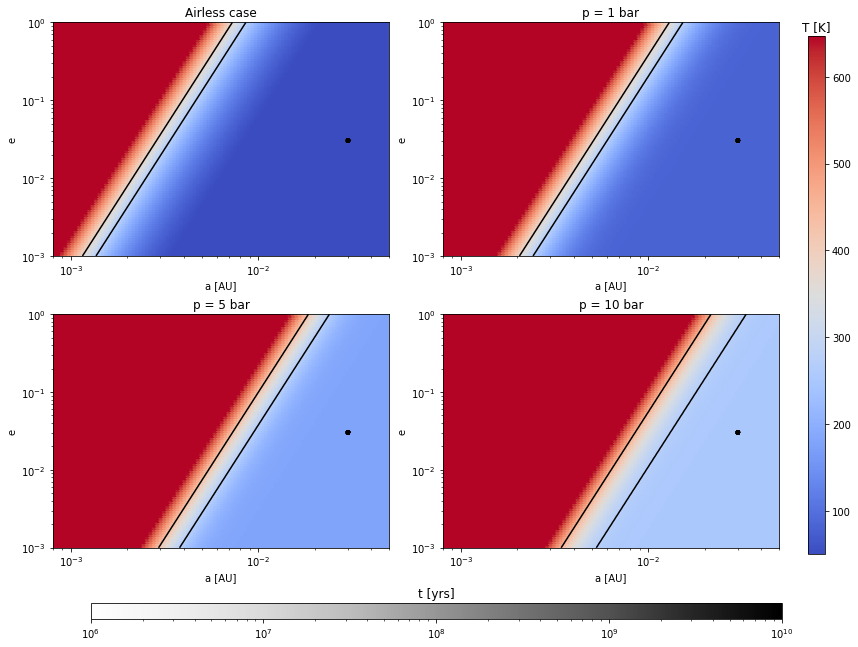

In [ ]:
fig = plt.figure(figsize=(12,9), constrained_layout = True)
gs = GridSpec(9, 9, figure = fig)
ax1 = fig.add_subplot(gs[0:4,0:4])
ax2 = fig.add_subplot(gs[0:4,4:8])
ax3 = fig.add_subplot(gs[4:8,0:4])
ax4 = fig.add_subplot(gs[4:8,4:8])

ax1.scatter(a/1.496e11, e, c = T_surface(a, e , m, 0), cmap = 'coolwarm', vmin=50, vmax=647.3)
k = ax1.scatter(a_ev/1.496e11, e_ev, c = (sol.t / 3.154e7), cmap = 'Greys', norm = colors.LogNorm(vmin= 1e6, vmax = 1e10), marker = '.')
ax1.contour(a/1.496e11, e, T_surface(a, e, m, 0), levels=[273, 373], colors = 'k')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('a [AU]')
ax1.set_ylabel('e')
ax1.set_title('Airless case')

ax2.scatter(a/1.496e11, e, c = T_surface(a, e , m, 1), cmap = 'coolwarm', vmin=50, vmax=647.3)
ax2.scatter(a_ev/1.496e11, e_ev, c = (sol.t / 3.154e7), cmap = 'Greys', norm = colors.LogNorm(vmin= 1e6, vmax = 1e10), marker = '.')
ax2.contour(a/1.496e11, e, T_surface(a, e, m, 1), levels=[273, 373], colors = 'k')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('a [AU]')
ax2.set_ylabel('e')
ax2.set_title('p = 1 bar')

ax3.scatter(a/1.496e11, e, c = T_surface(a, e , m, 5), cmap = 'coolwarm', vmin=50, vmax=647.3)
ax3.scatter(a_ev/1.496e11, e_ev, c = (sol.t / 3.154e7), cmap = 'Greys', norm = colors.LogNorm(vmin= 1e6, vmax = 1e10), marker = '.')
ax3.contour(a/1.496e11, e, T_surface(a, e, m, 5), levels=[273, 424], colors = 'k')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlabel('a [AU]')
ax3.set_ylabel('e')
ax3.set_title('p = 5 bar')

c = ax4.scatter(a/1.496e11, e, c = T_surface(a, e , m, 10), cmap = 'coolwarm', vmin=50, vmax=647.3)
ax4.scatter(a_ev/1.496e11, e_ev, c = (sol.t / 3.154e7), cmap = 'Greys', norm = colors.LogNorm(vmin= 1e6, vmax = 1e10), marker = '.')
ax4.contour(a/1.496e11, e, T_surface(a, e, m, 10), levels=[273, 453], colors = 'k')
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_xlabel('a [AU]')
ax4.set_ylabel('e')
ax4.set_title('p = 10 bar')


cb_ax = fig.add_axes([0.93, 0.15, 0.02, 0.8])
cbar = fig.colorbar(c, cax = cb_ax)
cbar.ax.set_title('T [K]')

cb_ax_t = fig.add_axes([0.1,0.05,0.8,0.025])
cbar_t = fig.colorbar(k, cax = cb_ax_t, orientation='horizontal')
cbar_t.ax.set_title('t [yrs]')

#fig.savefig('test.png', dpi = 600)

# **Changing initial conditions**

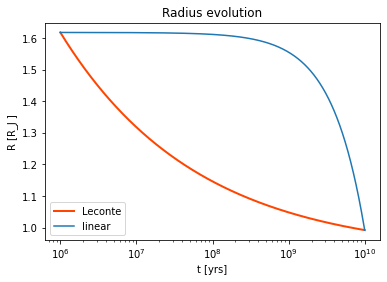

In [ ]:
def jupiter_radius(t, A, B, C):
  return A * np.exp(-B * np.log10(t)) + C

A = 20.043 * 7.149e9 #cm
B = 0.559  #adimentional
C = 0.917 * 7.149e9 #cm

t = np.logspace(np.log10(1e6), np.log10(1e10 ), 10000) 
ev2 = 1.61738854 - (1.61738854 - 0.99186116) / ((1e10 - 1e6) ) * t


plt.plot(t , jupiter_radius(t, A, B, C) / 7.149e9, color = 'orangered', lw = 2, label = 'Leconte')
plt.plot(t, ev2, label = 'linear')
plt.title('Radius evolution')
plt.xlabel('t [yrs]')
plt.ylabel('R [R_J ]')
plt.xscale('log')
plt.legend()
#plt.savefig('Radius_linear.png', dpi=600)

In [ ]:
def equations(t, y, m, r, sigma_m, M, sigma_M): 
  a, e, Omega_m, Omega_M = y
  G = 6.674e-8

  #Period_m = (2*np.pi)/np.sqrt(G*(M+m)) * pow(a,1.5)       #Assuming sincronous rotation!
  #Omega_m = (2*np.pi) / Period_m

  #dRdt = - 0.3 * 7.149e9 / ((1e7 - 1e4) * 3.154e7)
  #R =  1 * 7.149e9 + t * dRdt #Jupiter radii in cm
  #R = 1 * 7.149e9
  #print(R / 7.149e9)
  dRdt = - A * B * np.exp(- B * np.log10(t /  3.154e7)) / (np.log(10) * (t )) 
  R = jupiter_radius(t / 3.154e7, A, B, C) #cm
  
  T_m     = (1./9) * (m/(M*(M + m))) * (1. / r**10) * (1./sigma_m) * a**8 
  T_M     = (1./9) * (M/(m*(M + m))) * (1. / R**10) * (1./sigma_M) * a**8 
  n       = np.sqrt(G * (M+m)/pow(a,3))
  h       = (m*M)/(m+M) * np.sqrt(G * (m + M) * a * (1-e**2))
  I_m     = 2./5 * m * r**2
  I_M     = 2./5 * M * R**2
  gamma_m = h / I_m / Omega_m
  gamma_M = h / I_M / Omega_M

  dadt      = ((-a/T_m) * (N_a1(e**2) - (Omega_m / n) * N_a2(e**2))) + ((-a/T_M) * (N_a1(e**2) - (Omega_M / n) * N_a2(e**2)))
  dedt      = (- 9*e/2./T_m * (N_e1(e**2) - (11./18) * (Omega_m/n) * N_e2(e**2))) + (-9*e/2./T_M * (N_e1(e**2) - (11./18) * (Omega_M/n) * N_e2(e**2))) 
  #dPeriodm_dt = 3*np.pi / np.sqrt(G*(M+m)) * np.sqrt(a) * dadt
  dOmegamdt = Omega_m * gamma_m / 2 / T_m * (N_o1(e**2) - Omega_m / n * N_o2(e**2))
  #dOmegaMdt = - Omega_M * gamma_M / (2. * T_M) * (N_o1(e**2) - (Omega_M / n) * N_o2(e**2)) - 2./ R * dRdt 
  dOmegaMdt = - Omega_M * gamma_M / (2. * T_M) * (N_o1(e**2) - (Omega_M / n) * N_o2(e**2)) 

  dydt = [dadt, dedt, dOmegamdt, dOmegaMdt]
  return dydt

In [ ]:
def prepare_plots():
  fig = plt.figure(figsize=(12,9), constrained_layout = True)
  gs = GridSpec(9, 9, figure = fig)
  ax1 = fig.add_subplot(gs[0:4,0:4])
  ax2 = fig.add_subplot(gs[0:4,4:8])
  ax3 = fig.add_subplot(gs[4:8,0:4])
  ax4 = fig.add_subplot(gs[4:8,4:8])

  #ax1.plot(sol.t / 3.154e7, sol.y[0] * 6.685e-14, 'b', color = 'royalblue', lw=2)
  ax1.set_xscale('log')
  ax1.set_xlabel('t [yr]')
  ax1.set_ylabel('a [AU]')
  ax1.set_title('a(t)')

  #ax2.plot(sol.t / 3.154e7, sol.y[1], 'b', color = 'mediumorchid', lw=2)
  ax2.set_xscale('log')
  ax2.set_xlabel('t [yr]')
  ax2.set_ylabel('e')
  ax2.set_title('e(t)')

  #ax3.plot(sol.t / 3.154e7, (2 * np.pi) / (sol.y[3] * 3600), 'b', color = 'mediumseagreen', lw=2)
  ax3.set_xscale('log')
  ax3.set_xlabel('t [yr]')
  ax3.set_ylabel('Jupiter period [hr]')
  ax3.set_title('T_Jupiter(t)')

  #ax4.plot(sol.t / 3.154e7, (2 * np.pi) / (sol.y[2] * 3600), 'b', color = 'mediumseagreen', lw=2)
  ax4.set_xscale('log')
  ax4.set_xlabel('t [yr]')
  ax4.set_ylabel('Earth period [hr]')
  ax4.set_title('T_Earth(t)')

  return ax1, ax2, ax3, ax4


def plot_results(ax1, ax2, ax3, ax4, sol, k, kmax):
  cmap = plt.cm.get_cmap('hsv')
  rgb = cmap(k/kmax)
  ax1.plot(sol.t / 3.154e7, sol.y[0] * 6.685e-14, 'b', color = rgb, lw=2)
  ax2.plot(sol.t / 3.154e7, sol.y[1], 'b', color = rgb, lw=2)
  ax3.plot(sol.t / 3.154e7, (2 * np.pi) / (sol.y[3] * 3600), 'b', color = rgb, lw=2)
  ax4.plot(sol.t / 3.154e7, (2 * np.pi) / (sol.y[2] * 3600), 'b', color = rgb, lw=2)
  return ax1, ax2, ax3, ax4

def plot_ae(sol, k, kmax):
  cmap = plt.cm.get_cmap('hsv')
  rbg = cmap(k/kmax)
  plt.plot(sol.y[0] * 6.685e-14, sol.y[1], 'b', color = rgb, lw=2)
  return plt

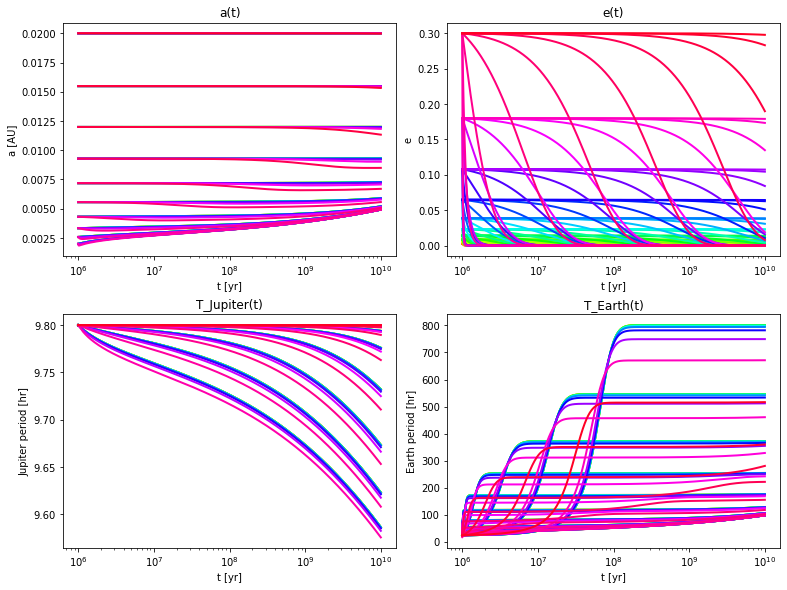

In [ ]:
#Jupiter and Earth as in Tommaso's paper

G = 6.674e-8
m = 5.972e27         #Earth mass in g            
r = 6.378e8          #Earth radius        
#sigma_m = 8.9795e-50 # 1./(g*cm^2*s)
sigma_m = 7.373219594793569e-51
M = 1.898e30         #Jupiter mass in g
sigma_M = 2.006e-60  # 1./(g*cm^2*s)

tin  = 1e6 * 3.154e7
tfin = 1e10 * 3.154e7

Omega_m0 = (2*np.pi)/(24 * 3600)
Omega_M0 = (2*np.pi)/(9.8 * 3600)

a0 = np.logspace(np.log10(2e-3), np.log10(2e-2), 10) * 1.496e13
e0 = np.logspace(np.log10(3e-3), np.log10(3e-1), 10)
a0, e0, = np.meshgrid(a0, e0)
a0 = np.reshape(a0, (100))
e0 = np.reshape(e0, (100)) 

#a0 = np.logspace(np.log10(5e-3), np.log10(8e-3), 10) * 1.496e13
#e0 = 0.3

solutions = []

ax1, ax2, ax3, ax4 = prepare_plots()
kmax = 100
for k in range(0,kmax):
  y0 = [a0[k], e0[k], Omega_m0, Omega_M0]
  #y0 = [a0[k], e0, Omega_m0, Omega_M0]
  sol = solve_ivp(equations, [tin, tfin], y0, method = 'BDF', rtol = 1e-12, atol = 1e-40, args=(m, r, sigma_m, M, sigma_M))
  solutions.append(sol)
  #print(k)
  if not sol.success:
    print(sol.message)
    Error
  plot_results(ax1, ax2, ax3, ax4, sol, k, kmax)

In [ ]:
E_radio = 4.6e20             #erg s^-1
sigma_B = 5.6704e-5          
D = 1.5
epsilon_r = 0.9
G = 6.67e-8
Q = 100 
M_J = 1.898e30
R = 6.995e9 
m = 5.972e27
r = 6.371e8

def n(m, a):
  return np.sqrt(G*(M_J + m) / (a**3))

def k2(m, r):
  g = (G*m)/pow(r, 2)
  rho_s = 3*m/(4*np.pi*pow(r, 3))
  mu = (19./2.) * (5e11)/(rho_s * g * r)
  return 1.5/(1 + mu)

def E_tidal(a, e, m, r):
  return (21. / 2) * G * k2(m, r) * (M_J**2) * (r**5) * n(m, a) * (e**2) / (Q * (a**6))

def E_tot(a, e, m, r):
  return E_tidal(a, e, m, r) + E_radio

def T_eff4(a, e, m, r):
  return E_tot(a, e, m, r) / (4 * np.pi * sigma_B * epsilon_r * R**2)

def tau(p):
  return 50.33 * p**(1.97)

def T_surface(a, e, m, r, p):
  return (T_eff4(a, e, m, r) * (1 + D* tau(p)) / 2)**(1. /4)

a = np.logspace(np.log10(0.8e-3*1.496e13), np.log10(5e-2*1.496e13), 100)
e = np.logspace(-3, np.log10(1), 100)

a, e, = np.meshgrid(a, e)

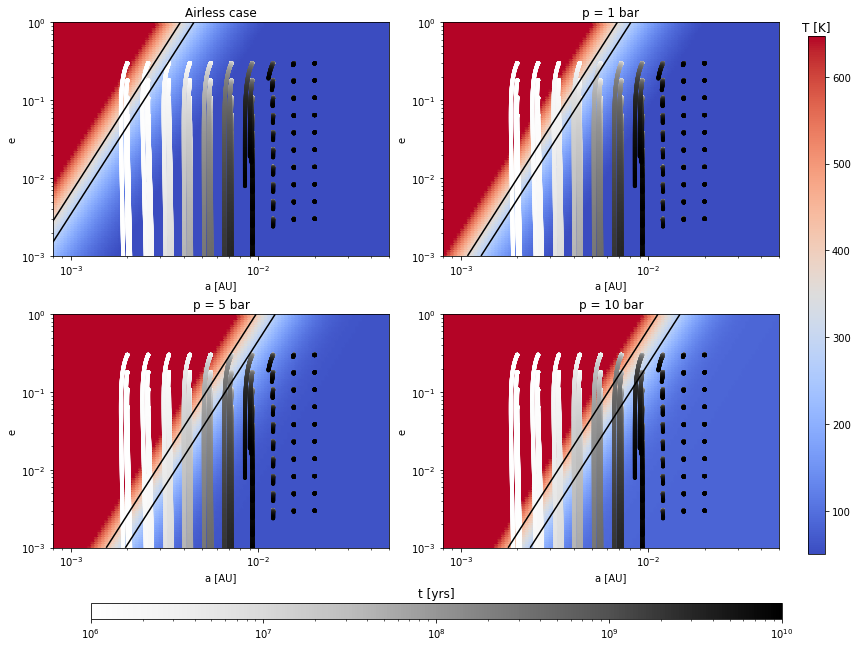

In [ ]:
fig = plt.figure(figsize=(12,9), constrained_layout = True)
gs = GridSpec(9, 9, figure = fig)
ax1 = fig.add_subplot(gs[0:4,0:4])
ax2 = fig.add_subplot(gs[0:4,4:8])
ax3 = fig.add_subplot(gs[4:8,0:4])
ax4 = fig.add_subplot(gs[4:8,4:8])

ax1.scatter(a/1.496e13, e, c = T_surface(a, e , m, r, 0), cmap = 'coolwarm', vmin=50, vmax=647.3)
ax1.contour(a/1.496e13, e, T_surface(a, e, m, r, 0), levels=[273, 373], colors = 'k')
for i in range(0, kmax):
  k = ax1.scatter(solutions[i].y[0] / 1.496e13, solutions[i].y[1], c = (solutions[i].t / 3.154e7), cmap = 'Greys', norm = colors.LogNorm(vmin= 1e6, vmax = 1e10), marker = '.')
ax1.set_ylim(1e-3, 1)
ax1.set_xlim(8e-4, 5e-2)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('a [AU]')
ax1.set_ylabel('e')
ax1.set_title('Airless case')

ax2.scatter(a/1.496e13, e, c = T_surface(a, e , m, r, 1), cmap = 'coolwarm', vmin=50, vmax=647.3)
#ax2.scatter(a_ev/1.496e13, e_ev, c = (sol.t / 3.154e7), cmap = 'Greys', norm = colors.LogNorm(vmin= 1e6, vmax = 1e10), marker = '.')
ax2.contour(a/1.496e13, e, T_surface(a, e, m, r, 1), levels=[273, 373], colors = 'k')
for i in range(0, kmax):
  ax2.scatter(solutions[i].y[0] / 1.496e13, solutions[i].y[1], c = (solutions[i].t / 3.154e7), cmap = 'Greys', norm = colors.LogNorm(vmin= 1e6, vmax = 1e10), marker = '.')
ax2.set_ylim(1e-3, 1)
ax2.set_xlim(8e-4, 5e-2)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('a [AU]')
ax2.set_ylabel('e')
ax2.set_title('p = 1 bar')

ax3.scatter(a/1.496e13, e, c = T_surface(a, e , m, r, 5), cmap = 'coolwarm', vmin=50, vmax=647.3)
#ax3.scatter(a_ev/1.496e13, e_ev, c = (sol.t / 3.154e7), cmap = 'Greys', norm = colors.LogNorm(vmin= 1e6, vmax = 1e10), marker = '.')
ax3.contour(a/1.496e13, e, T_surface(a, e, m, r, 5), levels=[273, 424], colors = 'k')
for i in range(0, kmax):
  ax3.scatter(solutions[i].y[0] / 1.496e13, solutions[i].y[1], c = (solutions[i].t / 3.154e7), cmap = 'Greys', norm = colors.LogNorm(vmin= 1e6, vmax = 1e10), marker = '.')
ax3.set_ylim(1e-3, 1)
ax3.set_xlim(8e-4, 5e-2)
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlabel('a [AU]')
ax3.set_ylabel('e')
ax3.set_title('p = 5 bar')

c = ax4.scatter(a/1.496e13, e, c = T_surface(a, e , m, r, 10), cmap = 'coolwarm', vmin=50, vmax=647.3)
#ax4.scatter(a_ev/1.496e13, e_ev, c = (sol.t / 3.154e7), cmap = 'Greys', norm = colors.LogNorm(vmin= 1e6, vmax = 1e10), marker = '.')
ax4.contour(a/1.496e13, e, T_surface(a, e, m, r, 10), levels=[273, 453], colors = 'k')
for i in range(0, kmax):
  ax4.scatter(solutions[i].y[0] / 1.496e13, solutions[i].y[1], c = (solutions[i].t / 3.154e7), cmap = 'Greys', norm = colors.LogNorm(vmin= 1e6, vmax = 1e10), marker = '.')
ax4.set_ylim(1e-3, 1)
ax4.set_xlim(8e-4, 5e-2)
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_xlabel('a [AU]')
ax4.set_ylabel('e')
ax4.set_title('p = 10 bar')


cb_ax = fig.add_axes([0.93, 0.15, 0.02, 0.8])
cbar = fig.colorbar(c, cax = cb_ax)
cbar.ax.set_title('T [K]')

cb_ax_t = fig.add_axes([0.1,0.05,0.8,0.025])
cbar_t = fig.colorbar(k, cax = cb_ax_t, orientation='horizontal')
cbar_t.ax.set_title('t [yrs]')

fig.savefig('test.png', dpi = 600)

# **Cilibrasi moons**

In [ ]:
def n(m, a):
  return np.sqrt(G*(M_J + m) / (a**3))

def k2_f(m, r):
  g = (G*m)/pow(r, 2)
  rho_s = 3*m/(4*np.pi*pow(r, 3))
  mu = (19./2.) * (5e11)/(rho_s * g * r)
  return 1.5/(1 + mu)

def E_tidal(a, e, m, r):
  return (21. / 2) * G * k2_f(m, r) * (M_J**2) * (r**5) * n(m, a) * (e**2) / (Q * (a**6))

def E_tot(a, e, m, r):
  return E_tidal(a, e, m, r) + E_radio

def T_eff4(a, e, m, r):
  return E_tot(a, e, m, r) / (4 * np.pi * sigma_B * epsilon_r * R**2)

def tau(p):
  return 50.33 * p**(1.97)

def T_surface(a, e, m, r, p):
  return (T_eff4(a, e, m, r) * (1 + D* tau(p)) / 2)**(1. /4)

In [ ]:
#Everything in cgs

E_radio = 4.6e17               #erg s^-1
sigma_B = 5.6704e-5          
D = 2
epsilon_r = 0.9
G = 6.67e-8
Q = 100 
mu = 5e11 #dyne per cm^2

#Planet = Jupiter 

M_J = 1.898e30
M = 1.898e30
R = 6.995e9 
sigma_M = 2.006e-60  # 1./(g*cm^2*s)
Omega_J = (2 * np.pi) / (9.8 * 3600)

#the Moon 

m = 5.879e27
rho = 3.01           #average density of Europa
r = pow(3 * m / (4 * np.pi * rho), 1./3)
#m = 5.879e27
#r = 6.371e8

#To calculate the love number and sigma 

mu_average = (38. / 3) * np.pi * mu * (r**4 / G / m**2)
delta_T = 1. / (2 * Omega_J * Q)
k2 = (3. / 2) / (1 + mu_average)
sigma_m = (2. / 3) * (k2 * delta_T * G) / (r**5)

#Initial conditions

#from 20 R_J to 160 R_J * 0.009558
#from 0.1 to 0.8 

a0 = np.logspace(np.log10(7.1492e10), np.log10(2.145e12), 10) 
e0 = np.logspace(np.log10(3e-2), np.log10(8e-1), 10)
a0, e0, = np.meshgrid(a0, e0)
a0 = np.reshape(a0, (100))
e0 = np.reshape(e0, (100))  

Omega_m0 = (2*np.pi)/(24 * 3600)
Omega_M0 = (2*np.pi)/(9.8 * 3600)

tin  = 1e6 * 3.154e7
tfin = 1e10 * 3.154e7

#Temperature conditions

a = np.logspace(np.log10(0.8e-3*1.496e13), np.log10(5e-2*1.496e13), 100)
e = np.logspace(-3, np.log10(1), 100)

a, e, = np.meshgrid(a, e)

print(sigma_m)
print(k2)
print(mu_average)
print(r)

1.6208017114173014e-51
0.3640188372575054
3.1206658735050743
775442235.5325109


In [ ]:
solutions = []

ax1, ax2, ax3, ax4 = prepare_plots()
kmax = 100
for k in range(0,kmax):
  y0 = [a0[k], e0[k], Omega_m0, Omega_M0]
  #y0 = [a0[k], e0, Omega_m0, Omega_M0]
  sol = solve_ivp(equations, [tin, tfin], y0, method = 'BDF', rtol = 1e-12, atol = 1e-40, args=(m, r, sigma_m, M, sigma_M))
  solutions.append(sol)
  #print(k)
  if not sol.success:
    print(sol.message)
    Error
  plot_results(ax1,ax2,ax3, ax4, sol, k, kmax)

NameError: ignored

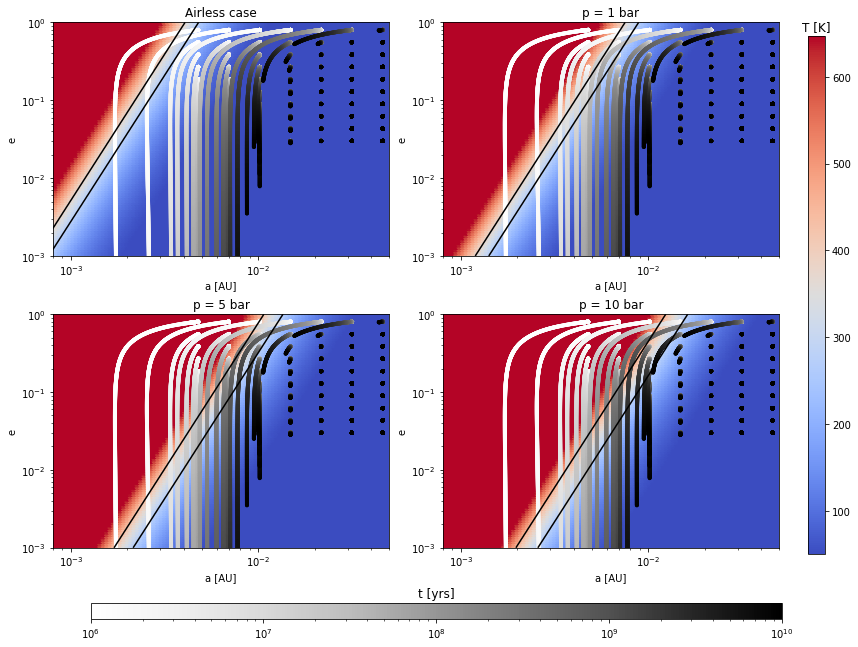

In [ ]:
fig = plt.figure(figsize=(12,9), constrained_layout = True)
gs = GridSpec(9, 9, figure = fig)
ax1 = fig.add_subplot(gs[0:4,0:4])
ax2 = fig.add_subplot(gs[0:4,4:8])
ax3 = fig.add_subplot(gs[4:8,0:4])
ax4 = fig.add_subplot(gs[4:8,4:8])

ax1.scatter(a/1.496e13, e, c = T_surface(a, e , m, r, 0), cmap = 'coolwarm', vmin=50, vmax=647.3)
ax1.contour(a/1.496e13, e, T_surface(a, e, m, r, 0), levels=[273, 373], colors = 'k')
for i in range(0, kmax):
  k = ax1.scatter(solutions[i].y[0] / 1.496e13, solutions[i].y[1], c = (solutions[i].t / 3.154e7), cmap = 'Greys', norm = colors.LogNorm(vmin= 1e6, vmax = 1e10), marker = '.')
ax1.set_ylim(1e-3, 1)
ax1.set_xlim(8e-4, 5e-2)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('a [AU]')
ax1.set_ylabel('e')
ax1.set_title('Airless case')

ax2.scatter(a/1.496e13, e, c = T_surface(a, e , m, r, 1), cmap = 'coolwarm', vmin=50, vmax=647.3)
ax2.contour(a/1.496e13, e, T_surface(a, e, m, r, 1), levels=[273, 373], colors = 'k')
for i in range(0, kmax):
  ax2.scatter(solutions[i].y[0] / 1.496e13, solutions[i].y[1], c = (solutions[i].t / 3.154e7), cmap = 'Greys', norm = colors.LogNorm(vmin= 1e6, vmax = 1e10), marker = '.')
ax2.set_ylim(1e-3, 1)
ax2.set_xlim(8e-4, 5e-2)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('a [AU]')
ax2.set_ylabel('e')
ax2.set_title('p = 1 bar')

ax3.scatter(a/1.496e13, e, c = T_surface(a, e , m, r, 5), cmap = 'coolwarm', vmin=50, vmax=647.3)
ax3.contour(a/1.496e13, e, T_surface(a, e, m, r, 5), levels=[273, 424], colors = 'k')
for i in range(0, kmax):
  ax3.scatter(solutions[i].y[0] / 1.496e13, solutions[i].y[1], c = (solutions[i].t / 3.154e7), cmap = 'Greys', norm = colors.LogNorm(vmin= 1e6, vmax = 1e10), marker = '.')
ax3.set_ylim(1e-3, 1)
ax3.set_xlim(8e-4, 5e-2)
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlabel('a [AU]')
ax3.set_ylabel('e')
ax3.set_title('p = 5 bar')

c = ax4.scatter(a/1.496e13, e, c = T_surface(a, e , m, r, 10), cmap = 'coolwarm', vmin=50, vmax=647.3)
ax4.contour(a/1.496e13, e, T_surface(a, e, m, r, 10), levels=[273, 453], colors = 'k')
for i in range(0, kmax):
  ax4.scatter(solutions[i].y[0] / 1.496e13, solutions[i].y[1], c = (solutions[i].t / 3.154e7), cmap = 'Greys', norm = colors.LogNorm(vmin= 1e6, vmax = 1e10), marker = '.')
ax4.set_ylim(1e-3, 1)
ax4.set_xlim(8e-4, 5e-2)
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_xlabel('a [AU]')
ax4.set_ylabel('e')
ax4.set_title('p = 10 bar')

cb_ax = fig.add_axes([0.93, 0.15, 0.02, 0.8])
cbar = fig.colorbar(c, cax = cb_ax)
cbar.ax.set_title('T [K]')

cb_ax_t = fig.add_axes([0.1,0.05,0.8,0.025])
cbar_t = fig.colorbar(k, cax = cb_ax_t, orientation='horizontal')
cbar_t.ax.set_title('t [yrs]')

fig.savefig('sim1.png', dpi = 600)